# Maximum Likelihood Estimation State Tomography Demo

Quantum State Tomography (QST) using maximum likelihood estimation (MLE).

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We start by defining the Hilbert space dimensionality of our system as `dim`, and the phase space grid for our measurement data - the Husimi Q representation of a state in phase space. This grid is defined to be `data_dim` x `data_dim`:

In [2]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

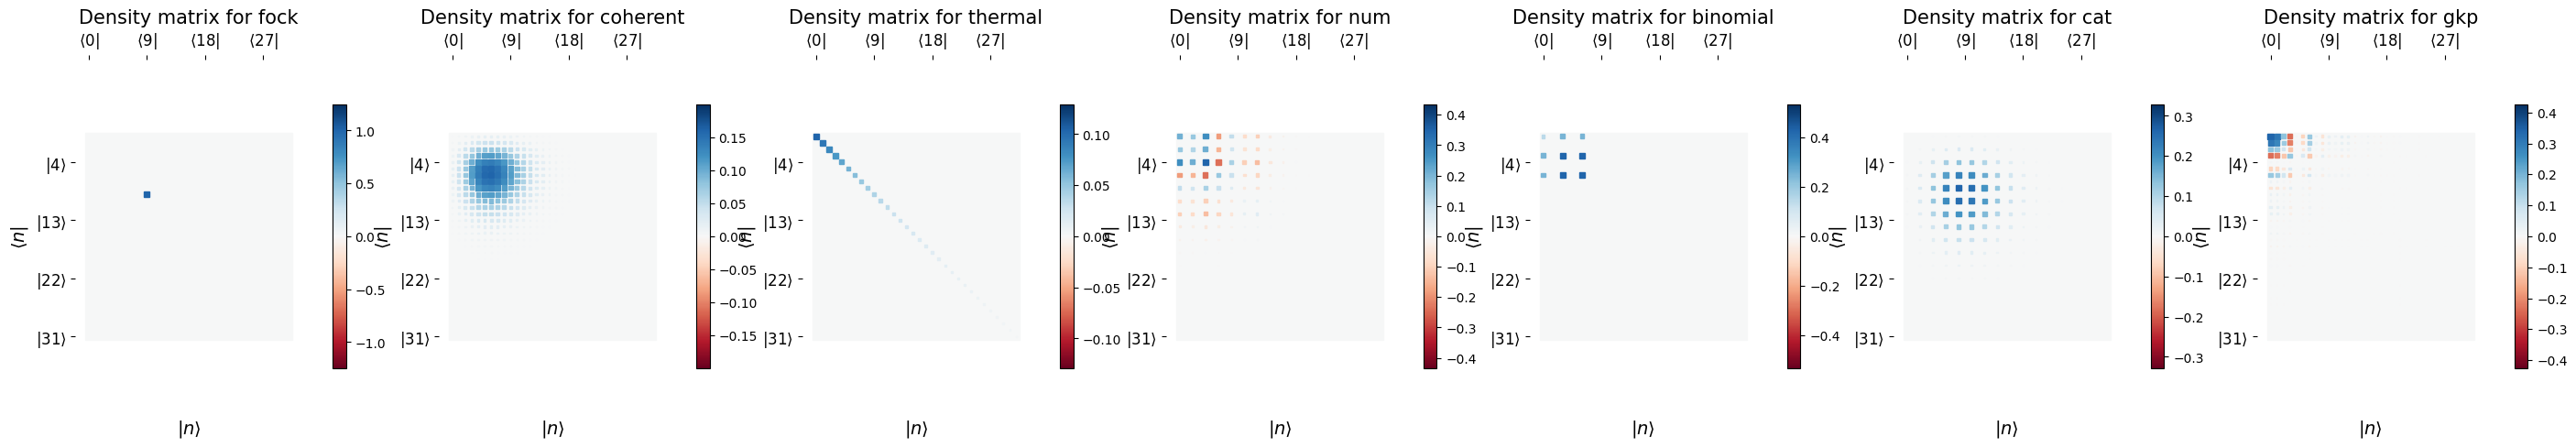

In [3]:
fock_test = qt.fock_dm(dim, 9)
coherent_test = qt.coherent_dm(dim, 2.5)
thermal_test = qt.thermal_dm(dim, 9)
num_test = qst.data.num_dm('M2', dim)
binomial_test = qst.data.binomial_dm(dim, 2, 2, 1)
cat_test = qst.data.cat_dm(dim, 3)
gkp_test = qst.data.gkp_dm(dim, [-5, 5], [-5, 5], 0.5, 4.5)

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_hinton(fock_test, ax=ax[0], label='fock')
qst.plot_hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_hinton(num_test, ax=ax[3], label='num')
qst.plot_hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_hinton(cat_test, ax=ax[5], label='cat')
qst.plot_hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for heterodyne detection of quantum states using `qsttoolkit.data.measurement_operators()`:

In [4]:
measurement_operators = qst.data.measurement_operators(dim, 'heterodyne', xgrid=xgrid, pgrid=pgrid)

We choose our test state and apply mixed state noise, and then create the POVM expectation probabilities for our given measurement regime:

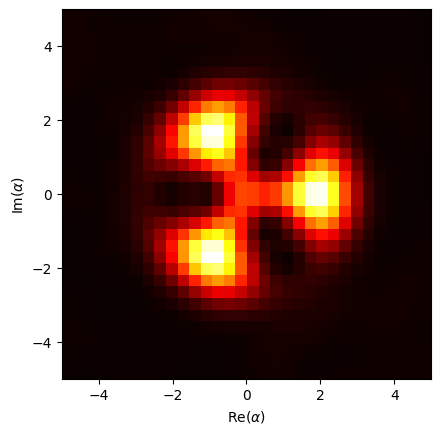

In [ ]:
test_state = qst.data.mixed_state_noise(binomial_test, 0.2)
expectation_values = qst.expectation(test_state, measurement_operators, numpy=True)
expectation_values /= np.sum(expectation_values)                                # Normalize to create valid probabilities

plt.imshow(expectation_values.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

We then sample our finite measurement shots of the state:

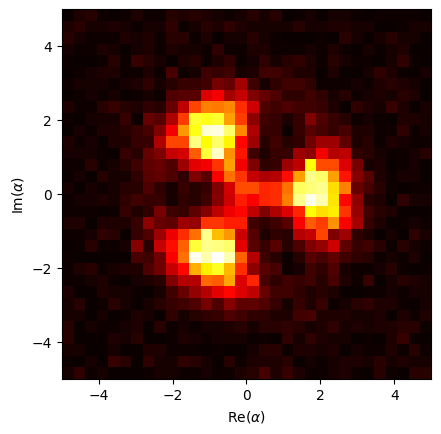

In [6]:
measurement_data = qst.data.measure_shots(expectation_values, num_shots=10000)

plt.imshow(measurement_data.reshape(data_dim, data_dim), extent=[-5, 5, -5, 5],cmap='hot')
plt.xlabel("Re($\\alpha$)")
plt.ylabel("Im($\\alpha$)")
plt.show()

## Modelling

We create an instance of the `qsttoolkit.tomography.MLEQuantumStateTomography` class, which handles the setup, performing and evaluation of the optimisation:

In [7]:
MLE_reconstructor = qst.tomography.MLEQuantumStateTomography()

Optimisation of the density matrix parameterisation using the `.reconstruct` method:

In [8]:
MLE_reconstructor.reconstruct(measurement_data,
                              measurement_operators,
                              initial_dm=qst.maximally_mixed_state_dm(dim).full(),     # MLE requires a 'starting guess'
                              epochs=500,
                              verbose_interval=50,
                              num_progress_saves=10,        # Save the progress of the training
                              true_dm=test_state)           # For calculating the fidelity of the reconstructed during training

Epoch 0/500, Loss: 6.931471805599452, Fidelity: 0.297712657962101
Epoch 50/500, Loss: 6.072073786573865, Fidelity: 0.5075961153359426
Epoch 100/500, Loss: 6.070223972970966, Fidelity: 0.5352787083895655
Epoch 150/500, Loss: 6.069486126175477, Fidelity: 0.5623639969947982
Epoch 200/500, Loss: 6.069074041832545, Fidelity: 0.5859414618378911
Epoch 250/500, Loss: 6.068822314368203, Fidelity: 0.6046235535505203
Epoch 300/500, Loss: 6.068661343868923, Fidelity: 0.6190111709245446
Epoch 350/500, Loss: 6.068553485337493, Fidelity: 0.6306502366955354
Epoch 400/500, Loss: 6.068478189307415, Fidelity: 0.639449920582084
Epoch 450/500, Loss: 6.0684240099942715, Fidelity: 0.6460952049021879
Reconstruction complete.


## Analysis

Model statistics over optimisation progress:

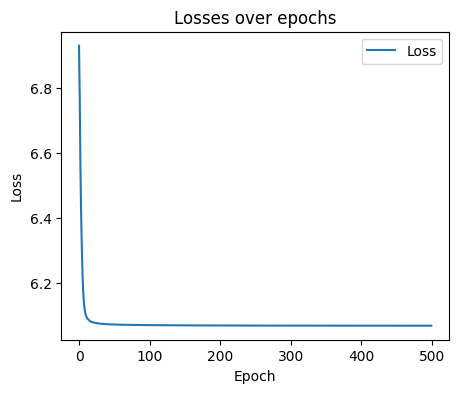

In [9]:
MLE_reconstructor.plot_losses()

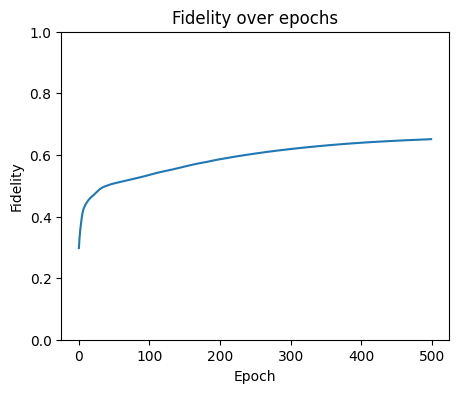

In [10]:
MLE_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

In [11]:
print(f"State fidelity: {qst.fidelity(test_state, MLE_reconstructor.reconstructed_dm)}")

State fidelity: 0.6512337474429487


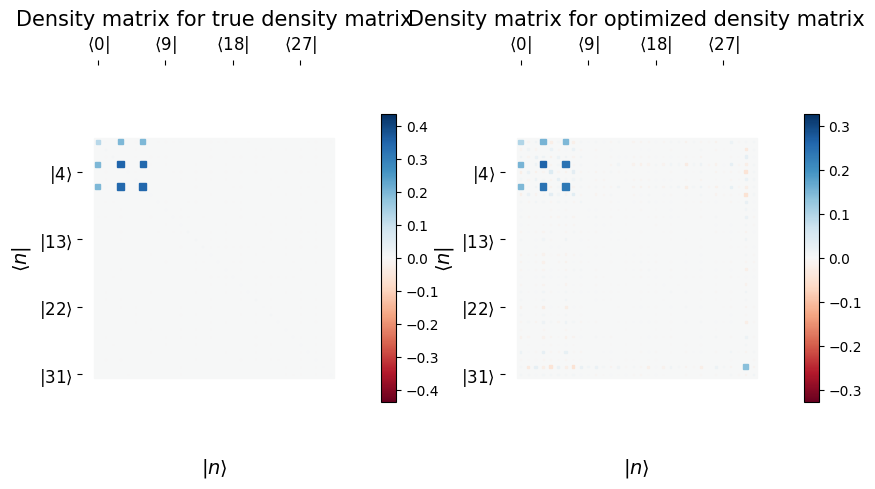

In [12]:
MLE_reconstructor.plot_comparison_hintons(test_state)

Comparison of the original test data, and data sampled from the reconstructed state:

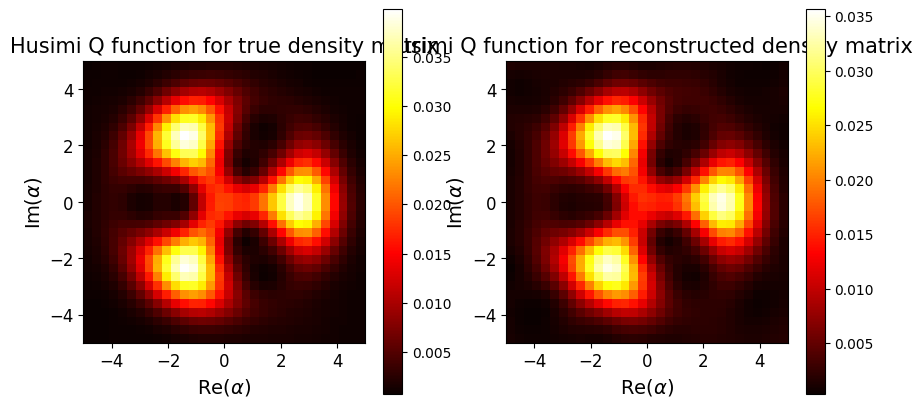

In [13]:
MLE_reconstructor.plot_comparison_husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parametrizations during optimisation:

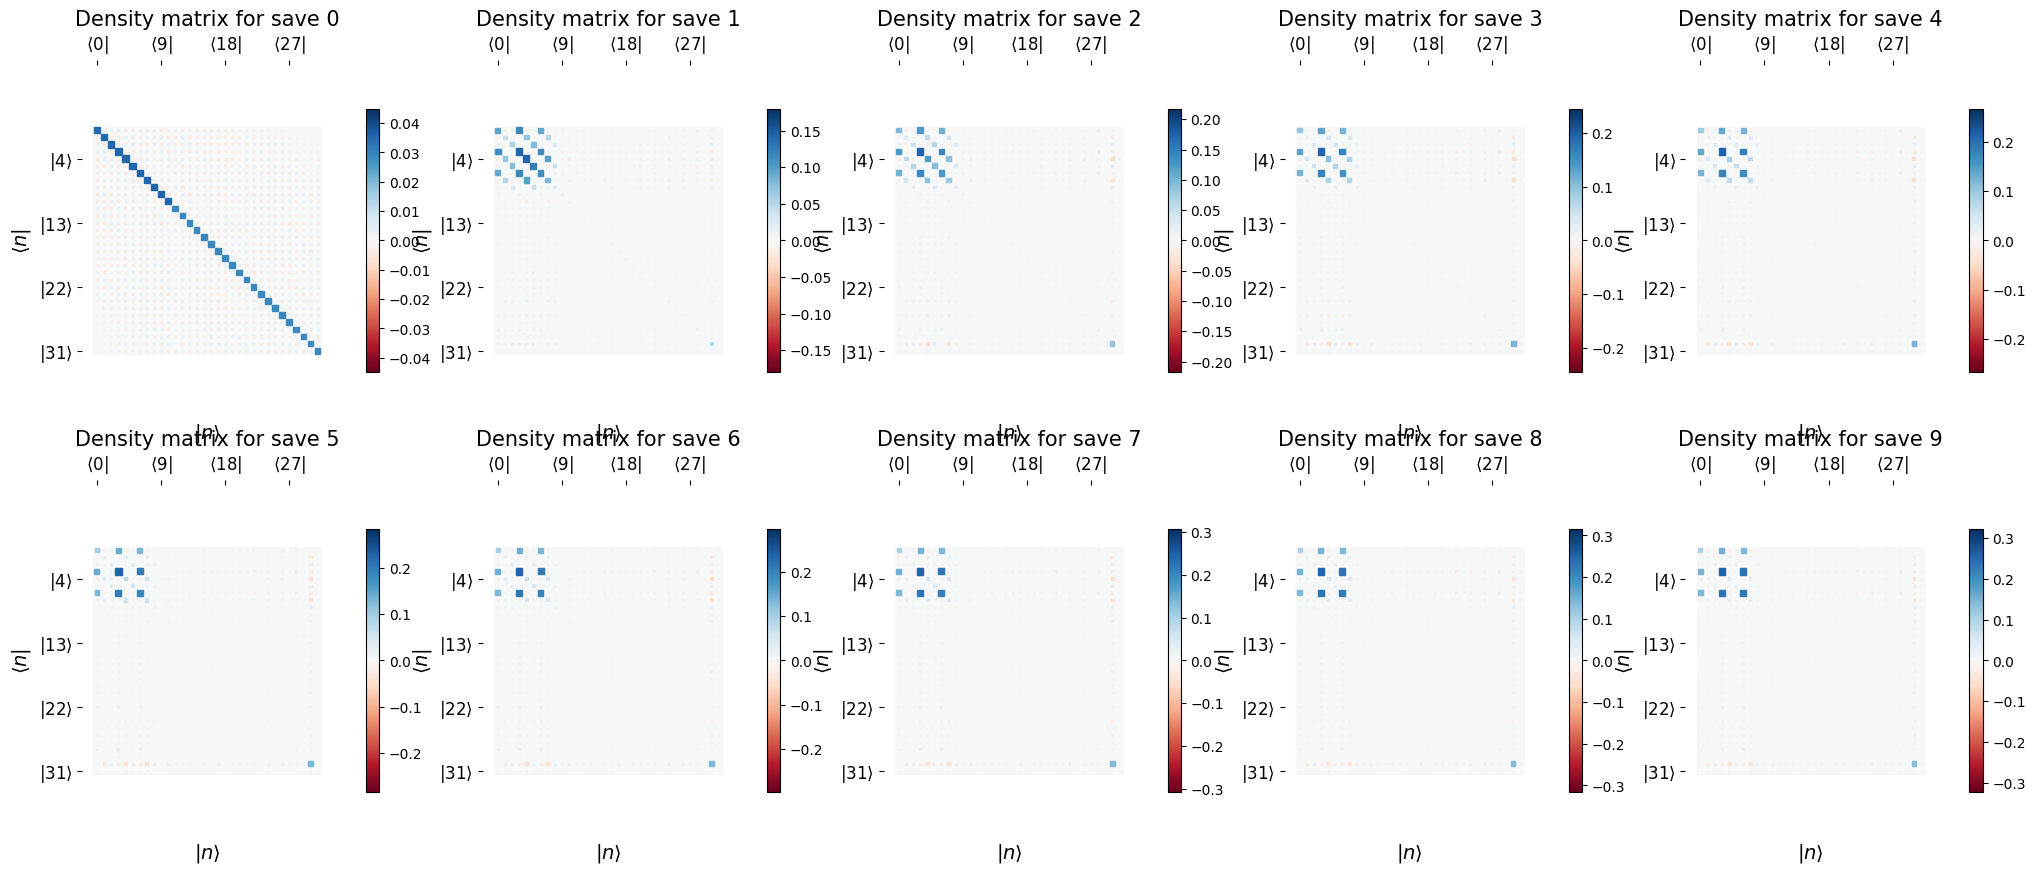

In [14]:
MLE_reconstructor.plot_intermediate_hintons()

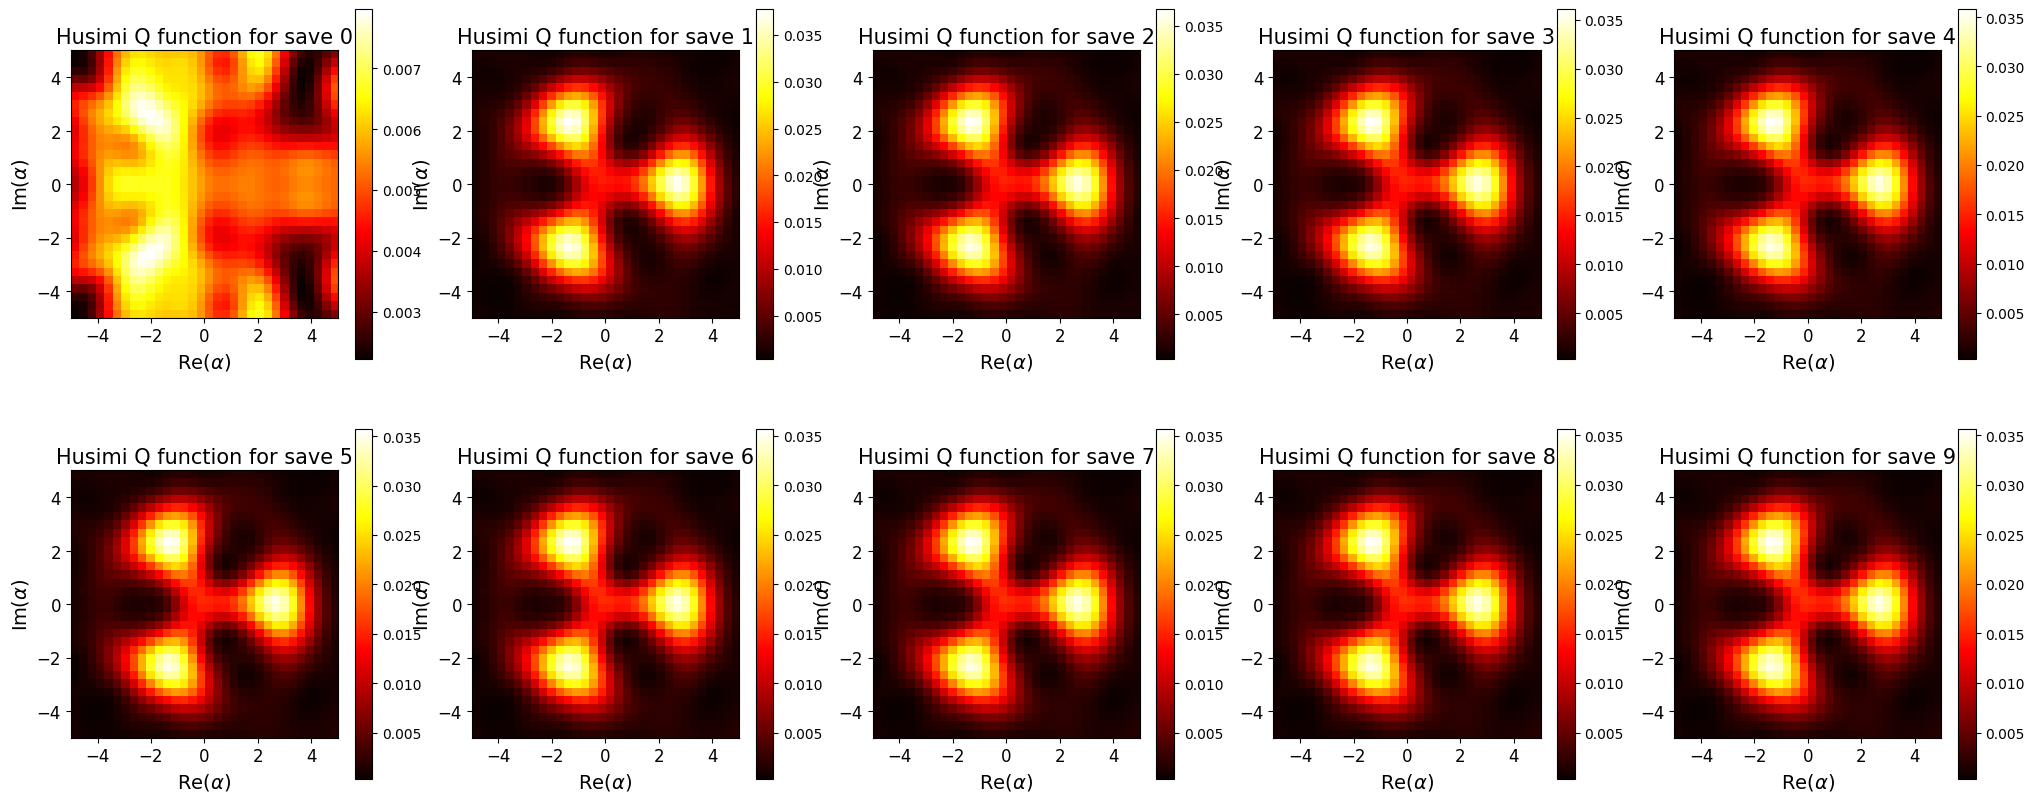

In [15]:
MLE_reconstructor.plot_intermediate_husimi_Qs(xgrid, pgrid)